<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.optimize import minimize

! pip install emcee
! pip install corner

import emcee
import corner

     |████████████████████████████████| 51kB 2.2MB/s 


# Данные

Подгрузим все данные.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Незашумленные кривые блеска:

In [26]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 70 #test

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [27]:
#https://arxiv.org/pdf/1512.05734.pdf - Rodney et al. 2016
#https://arxiv.org/pdf/2007.04106.pdf - Baklanov et al. 2021

dt_true = 9.5

magn_ratio = 1.14

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.14226212834118138


Функция для единого оформления графиков:

In [28]:
from matplotlib import rcParams

def grafik():
  
  rcParams['figure.figsize'] = (7,5)
  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  #plt.ylim(28.5, 26)
  plt.gca().invert_yaxis()
  plt.legend()
  plt.grid()
  plt.show()

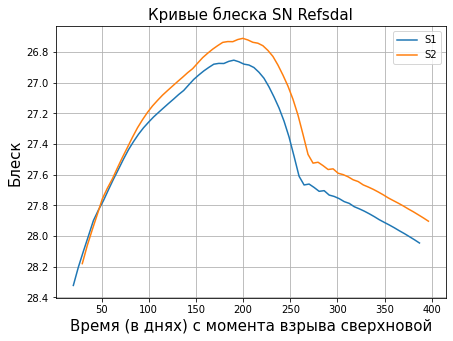

In [29]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум:

In [30]:
fluct1 = pd.read_csv('data/micro_data_S1_big.csv').to_numpy()
fluct2 = pd.read_csv('data/micro_data_S2_big.csv').to_numpy()
length=70

In [31]:
pd.DataFrame(fluct1)#.drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212
0,4106.0,6429.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.491947,-0.492950,-0.494602,-0.496261,-0.497793,-0.499438,-0.501453,-0.503017,-0.505312,-0.507078,-0.509629,-0.511923,-0.514664,-0.517426,-0.520105,-0.523520,-0.526800,-0.530608,-0.534623,-0.539514,-0.544819,-0.550605,-0.557734,-0.567826,-0.582004,-0.590391,-0.593847,-0.597014,-0.597571,-0.598066,-0.597902,-0.597103,-0.596118,-0.594873,-0.592918,-0.590624,-0.588666,-0.585950,-0.583289,-0.580763
1,7469.0,4546.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.142913,0.143042,0.143061,0.142998,0.143141,0.143091,0.142854,0.143081,0.142833,0.143090,0.142839,0.142926,0.142873,0.142770,0.142836,0.142869,0.142862,0.142845,0.142870,0.142922,0.142765,0.142798,0.142704,0.142666,0.142652,0.142693,0.142632,0.142672,0.142678,0.142518,0.142561,0.142602,0.142458,0.142409,0.142460,0.142446,0.142400,0.142419,0.142324,0.142271
2,8118.0,6656.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.864219,0.863252,0.863822,0.863429,0.863695,0.863860,0.863977,0.863655,0.863865,0.863915,0.863946,0.863811,0.863837,0.863585,0.863814,0.863489,0.863593,0.863634,0.863765,0.863680,0.863928,0.863787,0.863677,0.863559,0.863545,0.863478,0.863791,0.863691,0.863619,0.863699,0.863675,0.863457,0.863460,0.863727,0.863515,0.863602,0.863468,0.863704,0.863329,0.863329
3,3290.0,7827.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.579516,-0.579568,-0.579471,-0.579815,-0.579772,-0.579652,-0.579733,-0.579829,-0.579775,-0.580087,-0.579954,-0.579879,-0.580001,-0.580120,-0.580170,-0.580205,-0.580250,-0.580307,-0.580459,-0.580392,-0.580476,-0.580635,-0.580632,-0.580691,-0.580777,-0.580816,-0.580770,-0.580997,-0.581011,-0.581183,-0.581199,-0.581217,-0.581381,-0.581503,-0.581542,-0.581604,-0.581619,-0.581651,-0.581889,-0.581875
4,1629.0,8639.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.330687,-0.330750,-0.330797,-0.330770,-0.330680,-0.330841,-0.330864,-0.330926,-0.331129,-0.330918,-0.331321,-0.331003,-0.331146,-0.331125,-0.331143,-0.331290,-0.331353,-0.331557,-0.331498,-0.331488,-0.331533,-0.331600,-0.331811,-0.331673,-0.331707,-0.331924,-0.331868,-0.331950,-0.332058,-0.332030,-0.332084,-0.332213,-0.332269,-0.332230,-0.332363,-0.332401,-0.332496,-0.332617,-0.332658,-0.332762
5,2408.0,3460.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.794563,0.794405,0.794123,0.794011,0.794025,0.793781,0.794026,0.793988,0.793856,0.794261,0.794043,0.794001,0.794062,0.794093,0.793952,0.793799,0.793798,0.793692,0.793851,0.794016,0.794274,0.793886,0.793852,0.794070,0.794014,0.793914,0.793759,0.793697,0.793961,0.793824,0.793897,0.794031,0.793830,0.793555,0.793793,0.793892,0.793594,0.793735,0.793948,0.793818
6,5728.0,9104.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.122502,0.122223,0.122635,0.122387,0.122261,

In [32]:
pd.DataFrame(fluct2)#.drop([i for i in range(5,3+length-2)], axis=1).drop([i for i in range(3+length+2,3+2*length-2)], axis=1).drop([i for i in range(3+2*length+2,3+3*length-2)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212
0,5470.0,4630.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.757078,0.754415,0.754977,0.755658,0.753967,0.754953,0.756222,0.755084,0.754228,0.754238,0.754125,0.754783,0.754383,0.755326,0.754780,0.754474,0.753827,0.754132,0.754214,0.754326,0.754645,0.754790,0.754957,0.754532,0.754335,0.753838,0.754174,0.754597,0.754217,0.754535,0.753975,0.754305,0.754401,0.753986,0.754314,0.753897,0.753981,0.754639,0.754352,0.753935
1,4510.0,1733.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.524629,0.524209,0.524064,0.524067,0.523969,0.524018,0.524761,0.523269,0.523829,0.523648,0.523569,0.523810,0.523604,0.523438,0.523104,0.523602,0.522833,0.522942,0.522905,0.523230,0.522406,0.522838,0.522368,0.522134,0.522058,0.521584,0.522169,0.521693,0.521446,0.521612,0.521580,0.520712,0.520342,0.520520,0.520480,0.520306,0.520163,0.519867,0.519845,0.519614
2,8850.0,5032.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.480146,0.480723,0.481146,0.481325,0.480606,0.480969,0.480550,0.480195,0.480148,0.480248,0.480576,0.480364,0.479707,0.479672,0.479445,0.480262,0.479780,0.479806,0.479323,0.479083,0.479495,0.479242,0.479178,0.478629,0.479282,0.478441,0.478412,0.478270,0.478321,0.478248,0.477710,0.477758,0.477822,0.477727,0.477733,0.477542,0.477163,0.477160,0.476929,0.476961
3,8970.0,5956.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.365070,-0.364799,-0.364114,-0.365077,-0.365199,-0.366487,-0.366765,-0.367942,-0.368076,-0.369054,-0.369870,-0.370429,-0.370780,-0.371720,-0.372271,-0.372412,-0.373496,-0.374109,-0.375339,-0.376599,-0.376925,-0.377222,-0.378120,-0.379144,-0.380080,-0.381358,-0.382109,-0.382967,-0.384099,-0.384897,-0.385790,-0.386800,-0.387575,-0.388850,-0.389860,-0.391209,-0.392436,-0.393478,-0.394363,-0.395326
4,7929.0,133.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,1.976568,1.973699,1.972647,1.974780,1.975078,1.975659,1.976691,1.975316,1.976521,1.974948,1.974837,1.974142,1.976628,1.974375,1.975310,1.974581,1.976408,1.975915,1.977147,1.972929,1.974327,1.972793,1.972530,1.973545,1.974247,1.972655,1.972143,1.971068,1.972294,1.971612,1.973365,1.972351,1.972442,1.971260,1.970006,1.970863,1.970692,1.971269,1.970657,1.970719
5,8633.0,5610.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.332839,0.332332,0.331853,0.331914,0.331777,0.330983,0.330379,0.329626,0.329294,0.329312,0.329092,0.328079,0.326885,0.326518,0.326529,0.326289,0.325302,0.324706,0.323552,0.322890,0.322535,0.322030,0.321100,0.320327,0.319426,0.318491,0.318037,0.317307,0.316052,0.301466,0.282578,0.262774,0.245234,0.230106,0.213860,0.199477,0.186186,0.172249,0.161260,0.149776
6,2231.0,1593.0,70.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.086559,-0.087291,-0.089020,-0.089741,-0.090684,-0.092758,-0.093963,-0.095497,-0.096920,-0.098492,-0.101251,-0.102787,-0.104

In [33]:
xxs = (fluct1[:, 0], fluct2[:, 0])
yys = (fluct1[:, 1], fluct2[:, 1])
lengths = (fluct1[:,2].astype(int), fluct2[:,2].astype(int))
time_grids = (fluct1[:, 3:3+length], fluct2[:, 3:3+length])
dm_gausss = (fluct1[:, 3+length:3+2*length], fluct2[:, 3+length:3+2*length])
dm_flats = (fluct1[:, 3+2*length:3+3*length], fluct2[:, 3+2*length:3+3*length])

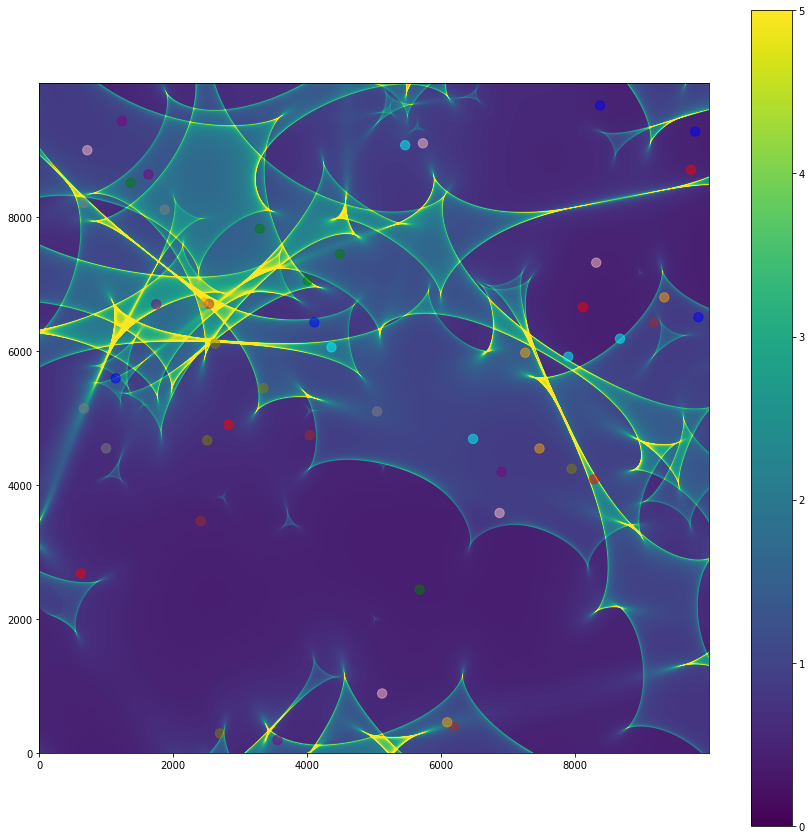

In [34]:
colors = 5*('blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive','cyan')

#417 - s1 - 346
#314 - s2 - 347

map_number = 346
s=1

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(15,15))
plt.imshow(image, origin='lower', vmin=0, vmax=5)
plt.colorbar()

for j in range(0, len(fluct1)):

  xx = xxs[s-1][j]
  yy = yys[s-1][j]
  length = lengths[s-1][j]
  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
 
  plt.gca().add_patch( plt.Circle((xx,yy), length, color=colors[j], alpha=0.5) )

plt.savefig('map_with_circles_S'+str(s)+'.png')
plt.show()

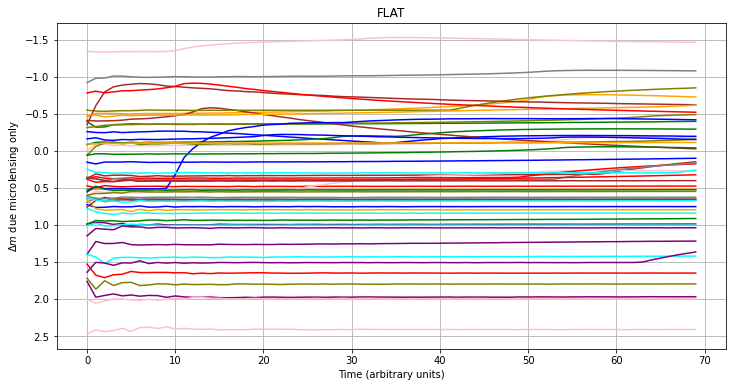

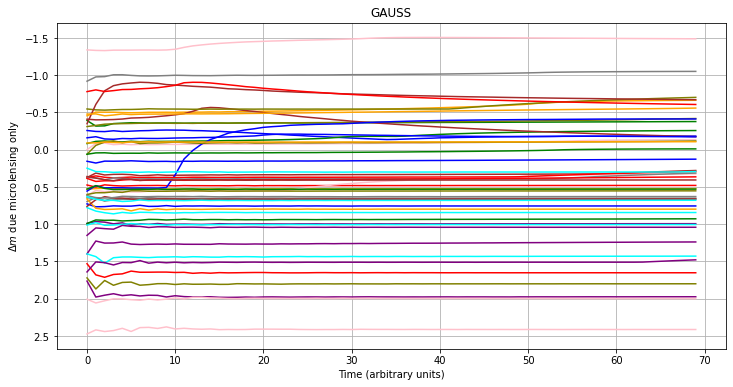

In [26]:
s=2

plt.figure(figsize=(12,6))

for j in range(0, len(fluct1)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
  
  #print('Number', j, ', center = (', xx, ',', yy,')')
  
  #plt.plot(time_grid, dm_gauss, label='gauss')
  plt.plot(time_grid, dm_flat, label='flat', color=colors[j])
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')

plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.title('FLAT')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_flat.png')
plt.show()

plt.figure(figsize=(12,6))

for j in range(0, len(fluct2)):

  time_grid = time_grids[s-1][j]
  dm_gauss = dm_gausss[s-1][j]
  dm_flat = dm_flats[s-1][j]
   
  plt.plot(time_grid, dm_gauss, label='gauss', color=colors[j])
  
plt.title('GAUSS')
plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
#plt.legend()
plt.grid()
plt.savefig('S'+str(s)+'_gauss.png')
plt.show()

In [36]:
#microlensing_noise1 = -2.5*np.log10(dm_gauss[8]) #np.random.normal(0., 0.1, len(t1_grid)) 
#microlensing_noise2 = -2.5*np.log10(dm_gauss[5]) #np.random.normal(0., 0.1, len(t2_grid))

lc1_noise = m1 + dm_flats[0][7]# microlensing_noise1
lc2_noise = m2 + dm_flats[1][6]#microlensing_noise2

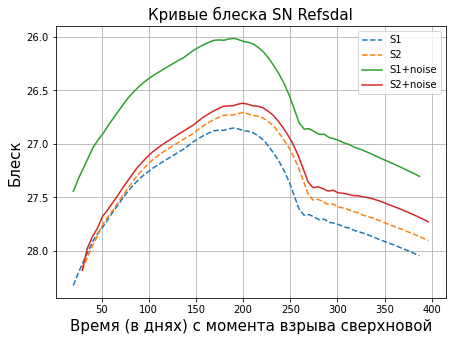

In [37]:
plt.plot(t1_grid, m1, linestyle='--', label="S1")
plt.plot(t2_grid, m2, linestyle='--', label="S2")

plt.plot(t1_grid, lc1_noise, label="S1+noise")
plt.plot(t2_grid, lc2_noise, label="S2+noise")

#lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true
#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

# emcee

Зададим необходимые функции. Логика следующая: мы "кормим" алгоритм данными из изображения S2, а потом сдвигаем их по времени и магнитуде и сравниваем с изображением S1.

In [38]:
def model(params, x1, x2, y2):
    dt, dmu = params
    #func = interpolate.interp1d(x2, y2)
    #return func(x1 + dt) - dmu
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, x2, y2))/1 )**2 )# + np.log(2*np.pi*sigmu**2) )
    return lnlike

def lnprior(params):
    dt, dmu = params
    if (-50. < dt < 100. and -5. < dmu < 5. ):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

In [39]:
def best_with_MCMC(dtTrue, dmTrue, lengthofchain, arguments, draw):

  #np.random.seed(45)
  #lnlike1 = lambda *args: -lnlike(*args)
  #initial = np.array([dtTrue, dmTrue]) + 0.01 * np.random.randn(2)
  #optim = minimize(lnlike1, initial, args=arguments)
  
  nwalkers = 100
  initial = [dtTrue, dmTrue]
  ndim = len(initial)
  p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = arguments )
  #p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
  #sampler.reset()
  sampler.run_mcmc(p0, lengthofchain, progress = True)

  samples = sampler.flatchain
  s  = samples[np.argmax(sampler.flatlnprobability)]

  #print("Initial dt = {0:.3f}".format(initial[0]))
  #print("Initial dm = {0:.3f}".format(initial[1]))
  #print("sigmu = {0:.3f}".format(optim.x[2]))

  #print('Best dt = {0:.3f}'.format(s[0]))
  #print('Best dmu = {0:.3f}'.format(s[1])) 
  #print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )

  if draw:
        
    plt.plot(arguments[0], arguments[1], label='S1')
    plt.plot(arguments[2], arguments[3], label='S2')
    #if show_all:
    #  for s in samples[np.random.randint(len(samples), size=50)]:
    #    plt.plot(arguments[0], model(s, arguments[0], arguments[2], arguments[3]), color="r", alpha=0.1)
    #else:
    best_fit_model = model(s, arguments[0], arguments[2], arguments[3])
    plt.plot(arguments[0], best_fit_model, color="r", label='Best fit')
    grafik()

    if False:
      fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
      chain = sampler.get_chain()
      labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']
      for i in range(ndim):
          ax = axes[i]
          ax.plot(chain[:, :, i], "k", alpha=0.3)
          ax.set_xlim(0, len(chain))
          ax.set_ylabel(labels[i])
          ax.yaxis.set_label_coords(-0.1, 0.5)
      axes[-1].set_xlabel("step number")
      #tau = sampler.get_autocorr_time()
      #print(tau)
      #flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
      #print(flat_samples.shape)
    
      fig = corner.corner(sampler.flatchain, 
                          show_titles=True, 
                          labels=['$\Delta t$', '$\Delta m$'], 
                          truths=[dt_true, dm_true], 
                          scale_hist=True, 
                          quantiles=[0.16, 0.5, 0.84])

  return s[0], s[1]

In [40]:
#best_dt, best_dm = best_with_MCMC(dtTrue=dt_true, 
#                                  dmTrue=dm_true, 
#                                  lengthofchain=1000, 
#                                  arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
#                                  draw=False)

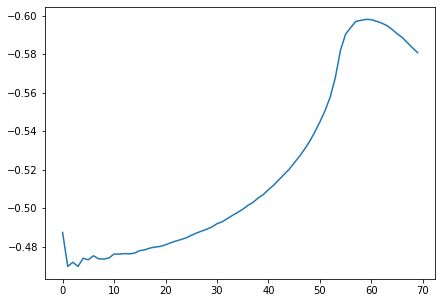

In [41]:
dm_flat1 = dm_flats[0][0]
dm_gauss1 = dm_gausss[0][0]
time_grid1 = time_grids[0][0]


plt.plot(time_grid1, dm_flat1)
plt.gca().invert_yaxis()

In [46]:
best_dt = []
best_dm = []

for i in range(0, len(fluct1)):
  for j in range(0, len(fluct2)):

    dm_flat1 = dm_flats[0][i]
    dm_flat2 = dm_flats[1][j]

    dm_gauss1 = dm_gausss[0][i]
    dm_gauss2 = dm_gausss[1][j]

    #МЕНЯТЬ ЗДЕСЬ
#-----------------------------------------
    microlensing_noise1 = dm_gauss1
    microlensing_noise2 = dm_gauss2
#-----------------------------------------
    lc1_noise = m1 + microlensing_noise1
    lc2_noise = m2 + microlensing_noise2

    best_dt1, best_dm1 = best_with_MCMC(dtTrue=dt_true, 
                                    dmTrue=dm_true, 
                                    lengthofchain=500, 
                                    arguments=(t1_grid, lc1_noise, t2_grid, lc2_noise), 
                                    draw = False)
  
    best_dt.append(best_dt1)
    best_dm.append(best_dm1)

100%|██████████| 500/500 [00:02<00:00, 228.00it/s]


True dt = 9.50
True dm = -0.14
GAUSS:


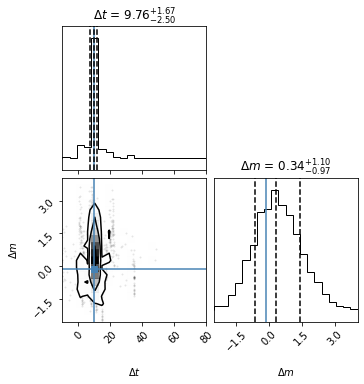

In [47]:
print("True dt = {0:.2f}".format(dt_true))
print("True dm = {0:.2f}".format(dm_true))
print("GAUSS:")

rcParams['figure.figsize'] = (10,10)
fig = corner.corner(np.transpose([best_dt, best_dm]), 
                    show_titles=True, 
                    range=((-10., 80.), 1.),
                    labels=['$\Delta t$', '$\Delta m$'], 
                    truths=[dt_true, dm_true], 
                    scale_hist=True, 
                    quantiles=[0.16, 0.5, 0.84])

plt.savefig('histo2.png')

In [48]:
pd.DataFrame([best_dt, best_dm]).to_csv('data/delays-big2-flat.csv', index=False)